< [Part 2: Basic Exploration](spotify_2_basic_exploration.ipynb) | [Main](index.ipynb) | [Part 4: Social Features](spotify_4_popularity_and_followers.ipynb) >

---

# Audio Feature Exploration

Now that we understand our dataset's basic features, we're ready to focus on the tracks' **audio**.

As part of its API, Spotify provides a number of pre-calculated [audio features](https://developer.spotify.com/web-api/object-model/#audio-features-object) for nearly every track on Spotify. These audio features were originally defined and calculated by [The Echo Nest](http://the.echonest.com/), which was acquired by Spotify in 2014. They include measures of a track's loudness, tempo, and whether or not a track has vocals. We could certainly analyze the audio ourselves to obtain our own audio features, but it will be interesting and more convenient to make use of the features that Spotify has calculated for us. If we wanted to go a little deeper, we could also make use of the Spotify API's more extensive [audio *analysis*](https://developer.spotify.com/web-api/get-audio-analysis/) functionality, which gives a much finer-grained set of audio metrics. For now, we'll focus on Spotify's standard audio features (which are calculated from those fine-grained metrics).

These features are of particular interest to us, as we will ultimately be building a dataset classifier that uses *only* audio features.

Let's dive in.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.interpolate import interp1d

#Collection of functions created in previous notebook
from groupby_lists import *

%matplotlib inline

#Custom seaborn/matplotlib settings
rc = {'axes.edgecolor': '0', 'axes.labelcolor': '0', 'grid.color': '0', 
      'figure.figsize': [6, 6], 'lines.linewidth': '2', 'text.color': '0', 
      'xtick.color': '0', 'ytick.color': '0' }
sns.set(context='notebook', style='white', font_scale=1.5, rc=rc)

pd.options.display.max_columns = 50

red = (1,0,0)
blue = (0,.475,1) #Same relative luminance (linearized) as primary red (approx)
purple = (.736,.343,.736) #Linearized average between above red and blue

df = pd.read_hdf('./data/df.h5', 'main')
by_genre = groupby_lists(df,'genres','genre')

# Valence

First, we'll have a look at the `'valence'` variable.

From the Spotify API [documentation](https://developer.spotify.com/web-api/object-model/#audio-features-object):
>**valence** (float): A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

Let's visualize the valence of our tracks using some custom plots. First, let's make a "violin plot with midcurve."

## Violin Plot with Midcurve

In order to investigate the difference between a given audio feature in each dataset, we'll visualize the feature's per-dataset distribution using a color-coded *violin plot*.

Our violin plot will estimate the probability densities of a given feature (using [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation?oldformat=true)) for each of the two datasets. It will then display them in **red** and **blue**, in a "mirrored" fashion, thus allowing for direct comparison. In addition, we'll highlight the differences between the two distributions by directly plotting their difference in **black**. Finally, we'll draw black lines at the calculated means of each distribution.

We'll let Seaborn's `violinplot` do most of the heavy lifting, and customize it by extracting the plot's density estimates, calculating our difference curve, and adding a number of plot elements:

In [24]:
# %%writefile violin_midcurve.py
# #Imports here for writefile magic only. Not Pythonic.
# import seaborn as sns
# import numpy as np
# from scipy.interpolate import interp1d
# red = (1,0,0)
# blue = (0,.475,1) #Same relative luminance as primary red (approx)

def extract_violin_curves(p):
    #Pull vertices from violin KDE estimate plot
    left_points = p.collections[0].get_paths()[0].vertices
    right_points = p.collections[1].get_paths()[0].vertices

    #Strip out points where x=0, corresponding to the vertical middle line.
    left_points = [ (a,b) for a,b in left_points if a!=0.0]
    right_points = [ (a,b) for a,b in right_points if a!=0.0]
    #left_points.sort(key=lambda x: x[1])
    #right_points.sort(key=lambda x: x[1])

    #Zip into separate x and y arrays
    x_left,y_left = zip(*left_points)
    x_right,y_right = zip(*right_points)

    #Interpolated function created from each kde which can be evaluated for 
    #arbitrary y values. Return 0 for out of range inputs.
    f_left = interp1d(y_left, x_left, bounds_error=False, fill_value=0.)
    f_right = interp1d(y_right, x_right, bounds_error=False, fill_value=0.)

    #Combine list of all y values
    y_all = np.concatenate((y_left,y_right))
    y_all.sort()
    
    return y_all, f_left, f_right

def violin_midcurve(y, data, hue='ds', y_label=None, 
                    hue_labels=['My Library','Billboard Top'],
                    order=None, hue_order=['nix','top'], bw='silverman',
                    colors=[ blue, red ], ax=None, 
                    ylim=None, title=None):

    """
    Generates a seaborn violin plot with a "midcurve" that indicates 
    difference in probability between two distributions.
    """
    
    #To do: Implement truncated KDE for distros with known, finite support 
    #(e.g. [0,1]). Also implement cross-validated bandwidth via sklearn.
    p = sns.violinplot('', y, hue, data, order, hue_order, bw=bw, cut=3, 
                       split=True, linewidth=0, palette=colors, color=(0,0,0), 
                       saturation=1, inner=None, showmedians=True, ax=ax,
                       gridsize=200)
    
    #Extract violin curves
    y_all, f_left, f_right = extract_violin_curves(p)

    #Create midpoint x values of the two KDE plots, and add to violinplot
    x_mid = ( f_left(y_all)+f_right(y_all) )
    p.plot(x_mid,y_all,c='k',lw=3)
    
    #Plot mean lines.
    #Use hue_order to determine which dataset is which
    if hue_order is None:
        hue_order = data[hue].unique()
    data_left = data[y][ data[hue]==hue_order[0] ]
    data_right = data[y][ data[hue]==hue_order[1] ]
    
    mean_left = data_left.mean()
    mean_right = data_right.mean()
    
    #Could set these to xlim values rather than +/- 100.
    p.plot( [-100, 0], [mean_left]*2, 'k-', lw=3)
    p.plot( [100, 0], [mean_right]*2, 'k-', lw=3)
    
    #Draw redundant y axis for mean line comparison
    p.tick_params(labelright=True)
    
    #Plot vertical line
    y_min = min(y_all)
    y_max = max(y_all)
    p.plot( [0]*2, [y_min,y_max], 'k-', lw=3)
    
    #Tight vertical axis
    p.autoscale(enable=True, axis='y', tight=True)
    
    #Custom vertical range
    if ylim is not None:
        p.set_ylim( [ ylim[0], ylim[1] ] )
    
    #Remove legend and add colored split variable indicators to bottom of frame
    if hue_labels is None:
        hue_labels = hue_order     
    p.legend_.remove()
    p.text(.25, -.04, hue_labels[0], horizontalalignment='center', 
           verticalalignment='center', transform = p.transAxes, 
           color=colors[0], size=16)
    p.text(.75, -.04, hue_labels[1], horizontalalignment='center', 
           verticalalignment='center', transform = p.transAxes, 
           color=colors[1], size=16)
    
    #Custom Y axis label. Simply capitalizes column name by default.
    if y_label is None:
        y_label = y.title() #Capitalize first letter
    p.set_ylabel(y_label)
        
    #Title, with default.
    if title is None:
        var = y.title() #Capitalize first letter
        title = 'Track ' + var + ' by Dataset'
    p.set_title(title)
     
    return p

Let's see the result!

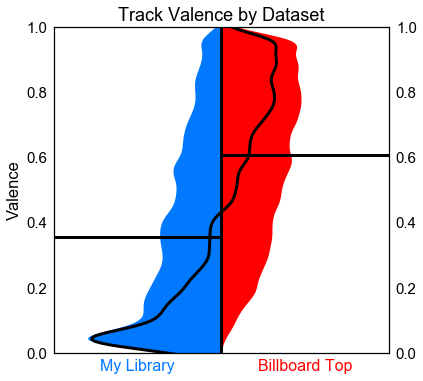

In [20]:
p = violin_midcurve( 'valence', df, ylim=[0,1], bw=.1 )

First, we can clearly see that the average valence of tracks in my library (horizontal line at approximately 0.35) is significantly lower than the average valence of Billboard hits (horizontal line at approximately 0.6). We can also see that both datasets seem to have a sloping distribution, with the Billboard dataset being biased towards high-valence tracks, and my library being biased towards low-valence tracks. This isn't particularly surprising, as I enjoy a lot of dark, harshe, or particularly aggressive music. Such music is less likely to reach Billboard's Hot 100 than "happy, cheerful, euphoric" tracks. 

There also appears to be a high density of *very* low-valence tracks in my library, and almost none in the Billboard dataset. Note that for very low valence values, the black **difference curve** nearly lines up with the blue distribution. This highlights the fact that nearly all of the very-low-valence tracks present are from my library. We can verify this by counting the number of tracks in each dataset with a valence of less than, say, 0.1:

In [34]:
df[ df.valence<0.1 ].ds.value_counts()

nix    1379
top      57
Name: ds, dtype: int64

That's around 20% of my library, but only 1% of the Billboard dataset! This alone is a decent dataset predictor.

---

**Note**: The difference curve in our violin plot gives a simple *single-feature classifier* for our datasets. For example, in our plot above, if the curve is to the *left* of the origin for a given valence, we might predict that tracks with that level of valence come from the `'nix'` dataset. Likewise, when the curve is to the *right* of the origin, we might predict that tracks with that valence come from the `'top'` dataset. There is a critical point around $0.45$ valence where both datasets are equally likely, indicating a "decision boundary" at $0.45$. If properly normalized, we could also use the curve to obtain a probabilistic classification (e.g. $P\left( \,\text{dataset}=\mathrm{nix} \mid \mathrm{valence} =0.1\right)$ ). We could then apply this to multiple features to construct a (kernel density estimate) [naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) for our datasets.

---

Let's see what artists and genres contribute to the extreme values that we see in our datasets. To do so, let's construct another custom plot.

## Extreme Artists/Genres Plots

In order to visualize the most extreme artists and genres (with respect to some feature), we'll build a simple color-coded point plot function. 

We'll find the artists (or genres) with the highest and lowest average value for a given feature and plot these as circles. The circle's $x$ co-ordinate corresponds to this average value, and the circle's color is determined by its prevalence in each dataset. 

Here we use a *diverging **blue-black-red** colormap*: Artists/genres that are only present in *my library* are colored **blue**, those that are only present in the *Billboard dataset* are colored **red**, and those with an equal presence in *both datasets* are colored **black**. Intermediate values interpolate linearly between these three colors.

Our main plotting function &mdash; `extremes_plot` &mdash; calculates each mean feature value, as well as the prevalence of each artist (or genre) in the two datasets (using our `ds_ratio` function). It uses Seaborn's `pointplot` function to plot these values, which we then alter and colorize. The general function is then wrapped up in either `extreme_artists_plot` or `extreme_genres_plot` depending on whether we are plotting artists or genres.

Note: Normally, Seaborn's `pointplot` will calculate its own aggregate values before plotting. Since we are passing in our own custom average values, we are bypassing this functionality while still having access to Seaborn's nice plot formatting.

In [42]:
# %%writefile extremes_plot.py
# #Imports here for writefile magic only. Not Pythonic.
# import seaborn as sns
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# red = (1,0,0)
# blue = (0,.475,1) #Same relative luminance as primary red (approx)

def ds_ratio(group):
    """Returns the fraction of rows that are in 'nix' dataset."""
    nix_count = (group=='nix').sum()
    top_count = (group=='top').sum()
    ratio = nix_count/(nix_count+top_count) #could smooth this
    return ratio

def extremes_plot(grouped, by, col, title=None, xlabel=None, min_tracks=4, 
                  xlim=None, axes=None):
    
    #Filter groupby object and re-group
    grouped_filtered = grouped.filter(lambda x: x[by].count()>=min_tracks
                                   ).groupby(by)
    
    #Aggregate over "col" to obtain mean column and dataset ratio column
    df_temp = grouped_filtered[col].mean().reset_index()
    df_temp['ds_ratio'] = grouped_filtered.ds.agg(ds_ratio).values
    
    #Sort, and store head and tail
    df_temp.sort_values(by=col, inplace=True, ascending=False)
    df_temp_head = df_temp.head(5)
    df_temp_tail = df_temp.tail(5)

    #Set colormap to visualize dataset ratio. 
    #'top'=red, 'nix'=blue, mixed=black
    c1 = red
    c2 = (0,0,0)
    c3 = blue
    cm_list = [ (0, c1), (0.5, c2), (1, c3) ]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'mymap', cm_list, N=256, gamma=1.0)
    colors_head = [cmap(ratio) for ratio in df_temp_head.ds_ratio.values]
    colors_tail = [cmap(ratio) for ratio in df_temp_tail.ds_ratio.values]

    #Make axes if none passed in
    if axes is None:
        fig, axes = plt.subplots(2,1)
        fig.set_size_inches(2, 4)
    (ax1,ax2) = axes
    
    #Ensure that x axes are shared
    ax1.get_shared_x_axes().join(ax1, ax2)

    #Get figure from subplot
    fig = plt.gcf()

    #Top pointplot
    sns.pointplot(y=by, x=col, data=df_temp_head, palette=colors_head,
                  join=False, scale=1.4, ax=ax1)
    
    #Remove labels from top plot
    ax1.set_ylabel('')
    ax1.set_xlabel('', visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)

    #Bottom pointplot
    sns.pointplot( y=by, x=col, data=df_temp_tail, palette=colors_tail, 
                join=False, scale=1.4, ax=ax2)
    ax2.set_ylabel('')
       
    #Capitalize column name for xlabel by default
    if xlabel is None:
        xlabel = col.title() #Capitalize first letter
    ax2.set_xlabel(xlabel)

    #Set title and title position
    ax1.set_title(title)
    ax1.title.set_position([.5, 1.07])

    #Position tweaks and x limits
    plt.subplots_adjust(hspace=.1);
    if xlim is not None:
        ax1.set_xlim(xlim)
    
    return fig


def extreme_artists_plot(df, col, title=None, xlabel=None, min_tracks=4, 
                         xlim=None, axes=None):
    
    grouped = df.groupby('name_artist')
    by = 'name_artist'
    
    #Title, with default.
    if title is None:
        var = col.title() #Capitalize first letter
        title = 'Artists with Highest and Lowest ' + var
    
    fig = extremes_plot(grouped, by, col, title=title, xlabel=xlabel,
                         min_tracks=min_tracks, xlim=xlim, axes=axes)
    
    return fig


def extreme_genres_plot(by_genre, col, title=None, xlabel=None, min_tracks=16, 
                        xlim=None, axes=None):
    grouped = by_genre
    by = 'genre'
    
    #Title, with default.
    if title is None:
        var = col.title() #Capitalize first letter
        title = 'Genres with Highest and Lowest ' + var
    
    fig = extremes_plot(grouped, by, col, title=title, xlabel=xlabel, 
                         min_tracks=min_tracks, xlim=xlim, axes=axes)
    
    return fig

Let's test it on `'valence'`.

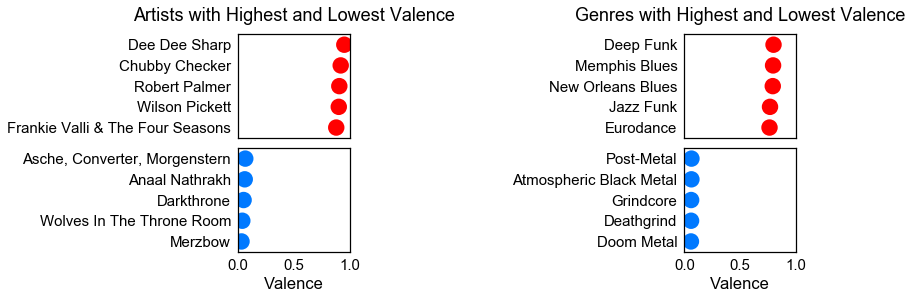

In [43]:
col = 'valence'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, xlim=[0,1], axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, xlim=[0,1], axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

We can clearly see that all of the lowest-valence tracks and genres are found solely in my library, while the highest-valence tracks and genres are found solely in the Billboard dataset. 

The highest valence artists are mostly pop musicians from the 60s-70s, and some of the highest valence genres are &mdash; perhaps ironically &mdash; variants of **Blues**.

The lowest valence artists are all **[Harsh Noise](https://en.wikipedia.org/wiki/Harsh_noise)**, **[Black Metal](https://en.wikipedia.org/wiki/Black_metal)**, and **[Powernoise](https://en.wikipedia.org/wiki/Power_noise)** artists, while the lowest valence genres mostly cover the darker variants of **[Extreme Metal](https://en.wikipedia.org/wiki/Extreme_metal)**.

---

Before moving on, let's investigate the spike in extremely-low-valence tracks in our dataset to see a puzzling phenomenon:

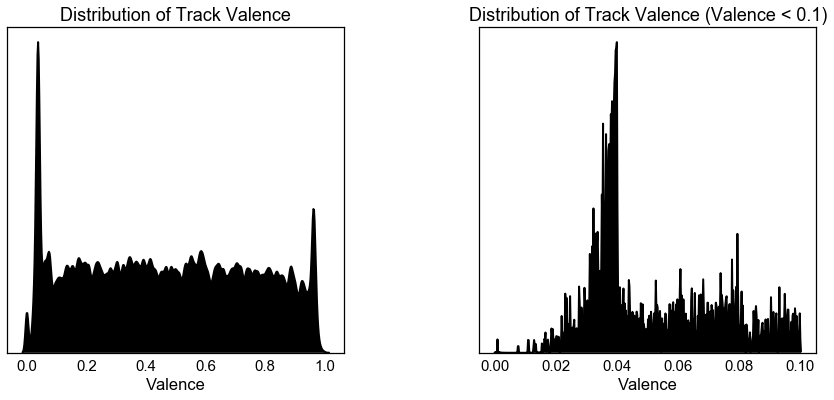

In [45]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))

p = sns.kdeplot(df.valence.dropna(), shade=True, legend=False, color='k', 
                alpha=1, fillstyle='full', bw=.005,gridsize=500, ax=ax1 )
ax1.set_yticklabels([])
ax1.set_title('Distribution of Track Valence')
ax1.set_xlabel('Valence')

p = sns.kdeplot(df[df.valence<.1].valence.dropna(), shade=True, legend=False, 
                color='k', alpha=1, fillstyle='full', bw=.0001, gridsize=500, 
                ax=ax2 )
ax2.set_yticklabels([])
ax2.set_title('Distribution of Track Valence (Valence < 0.1)')
ax2.set_xlabel('Valence')

plt.subplots_adjust(wspace=.4)

On the left, we have the valence distribution for the entire dataset, and on the right we've zoomed in on the low-valence peak. A sharp peak occurs at approximately 0.04 valence, with an apparent cluster of tracks to the left and a sharp drop to the right. The number of tracks with exactly 0 valence is dwarfed by this peak. 

I've yet to determine the cause of this phenomenon, and &mdash; as we will soon see &mdash; such behavior is unique to the `'valence'` feature. Since valence is calculated using a machine learning algorithm trained on human-expert training data, this might simply be an artifact of discretization in the human-generated input.

# Acousticness and Instrumentalness

Now, let's inspect the `'acousticness'` and '`instrumentalness'` variables.

From the Spotify API [documentation](https://developer.spotify.com/web-api/object-model/#audio-features-object):
>**acousticness** (float):	A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

>**instrumentalness** (float): Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

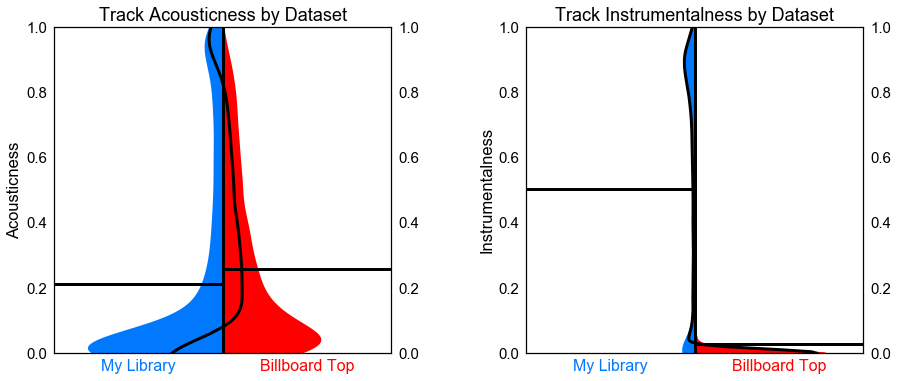

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
p = violin_midcurve( 'acousticness', df, ylim=[0,1], ax=ax1 )
p = violin_midcurve( 'instrumentalness', df, ylim=[0,1], bw=.1, ax=ax2 )
plt.subplots_adjust(wspace=.4)

Focusing on `'acousticness'`, we can see that both datasets have approximately the same average acousticness. Both datasets have a high density at low acousticness, with my library having a relatively high number of *very* low-acousticness tracks. My library also has significantly more highly acoustic tracks than the Billboard dataset. This may be due to the presence of e.g. Classical music in my library, which is not present in the Billboard dataset (more on this soon).

As far as `'instrumentalness'` goes, we see a large spike at 0 instrumentalness (and a nearly-zero average instrumentalness) in the Billboard dataset. This makes sense, since most hit tracks will have vocals. In contrast, my library has spikes at both very high and very low instrumentalness, with an average instrumentalness of about one half.

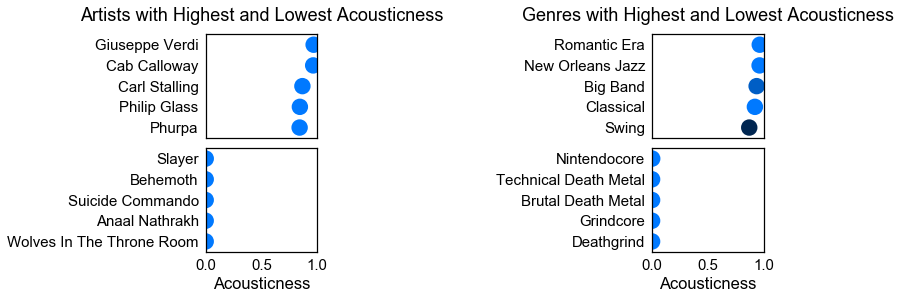

In [9]:
col = 'acousticness'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, xlim=[0,1], axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, xlim=[0,1], axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

Unlike `'valence'`, both extremely high and low `'acousticness'` tracks come almost entirely from my library. The highest-acousticness artists and genres represent mostly **Classical** and **Jazz**, while the lowest-acousticness comes mostly from various forms of **Metal**. This is unsurprising, as Metal is largely defined by its heavy use of distorted, *electric* guitar.

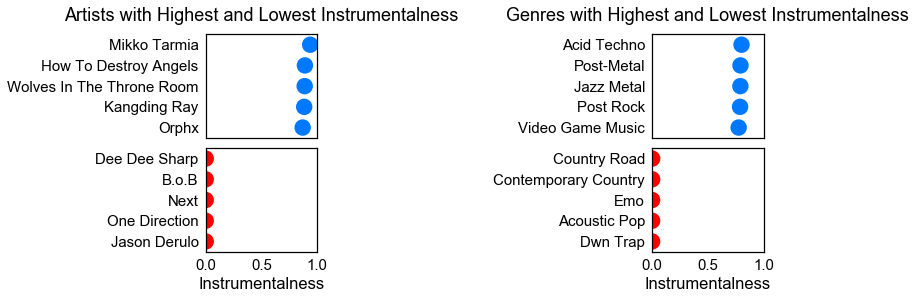

In [10]:
col = 'instrumentalness'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, xlim=[0,1], axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, xlim=[0,1], axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

As with `'valence'`, `'instrumentalness'` divide the datasets well. The most instrumental artists and genres come primarily from my library, and include **Video Game Sountracks**, **Techno**, **Industrial**, and instrumental **Black Metal**. 

The artists/genres with the lowest instrumentalness all come from the Billboard dataset, and all have *zero* average instrumentalness. In fact, fraction of tracks in the Billboard dataset with an instrumentalness of exactly 0 is quite large:

In [61]:
df[ df.instrumentalness==0 ].ds.value_counts()

top    2203
nix     165
Name: ds, dtype: int64

Around 40% of the Billboard tracks have zero instrumentalness, compared to around 3% of my library. Again, this is perhaps unsurprising since most hit singles have vocals.

Let's have a look at a few rare hits with high instrumentalness:

In [24]:
df[ (df.instrumentalness>0.80)&(df.ds=='top') ].sort_values( 
    by='popularity', ascending=False)[cols].head()

,name,name_artist,instrumentalness,decade
8432,Children,Robert Miles,0.812,1990.0
11042,Green Onions (45 version),Booker T. & the M.G.'s,0.906,1960.0
8952,I Ran,A Flock Of Seagulls,0.807,1980.0
11275,Classical Gas,Mason Williams,0.902,1960.0
9230,"Axel F - From ""Beverly Hills Cop""",Harold Faltermeyer,0.876,1980.0


"Children" is a very popular dance track from the 90s, and "Axel F" is an 80s electronic track that gained massive popularity due to its use as the de facto theme song for the popular movie "Bevery Hills Cop."

"Classical Gas" is a very popular 60s classical-guitar-driven track, and "Green Onions" is a 60s instrumental track that has [made its way into countless movie soundtracks](https://thenostalgiablog.com/2014/06/12/the-song-green-onions-seems-to-be-in-every-movie/).

"I Ran" stands out as a track that is clearly [not instrumental](https://www.youtube.com/watch?v=iIpfWORQWhU) but is assigned a relatively high instrumentalness by Spotify.

---

In order to explore how certain audio features have changed over the years, let's define another custom plot.

## Decade Violin Plot

Let's visualize how a given feature's distribution evolves over the years. We'll focus on the Billboard's ranking `'decade'`, as we've seen how it is a more reliable indicator of release date than `'release_year'`. We'll visualize said distribution over the decades using Seaborn's `violinplot` and `pointplot` functions.

In [69]:
# %%writefile decade_violinplot.py
# #Imports here for writefile magic only. Not Pythonic.
# import seaborn as sns

def decade_violinplot(df, col, ylabel=None, ylim=None, title=None):

    #Plot violins and points.
    colors = sns.color_palette( [(0,0,0)] )
    p = sns.violinplot(x='decade',y=col,data=df, split=False, palette=colors, 
                       saturation=1, scale='width', width=0.5, inner='point', 
                       cut=2, linewidth=0)
    p = sns.pointplot(x='decade',y=col,data=df, color='w', join=False, ci=None, 
                      scale=.5)
    
    #Set Y range
    if ylim is not None:
        p.set_ylim(ylim)
    
    #Labels
    #Capitalize column name for ylabel by default
    if ylabel is None:
        ylabel = col.title() #Capitalize first letter
    p.set_ylabel(ylabel)
    p.set_xlabel('Decade')
    p.set_xticklabels(['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']);
    
    #Title, with default.
    if title is None:
        var = col.title() #Capitalize first letter
        title = 'Track ' + var + ' by Decade'
    p.set_title(title)
    
    return p

Let's use our new function to visualize acousticness over the decades:

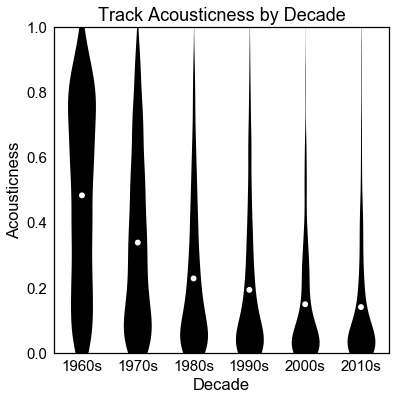

In [70]:
p = decade_violinplot( df, 'acousticness', ylim=[0,1] )

This shows a clear decrease in acousticness over the decades, with probability density being squeezed down toward very low acousticness as the decades increase. 

While this is perhaps an obvious result, it illustrates the use of our `decade_violinplot`, and is useful for comparison with the less-obvious patterns that we will see later.

# Duration

From the Spotify API [documentation](https://developer.spotify.com/web-api/object-model/#audio-features-object):

>**duration_ms** (int): The duration of the track in milliseconds.

(Recall that we converted duration from milliseconds to minutes in the data scraping stage)

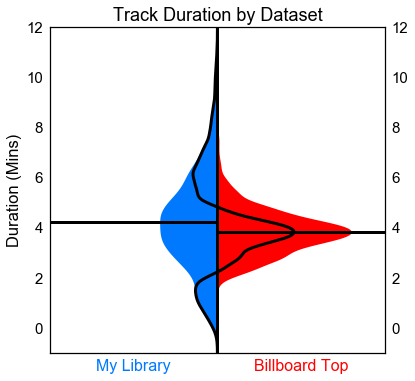

In [86]:
p = violin_midcurve( 'duration_mins', df[df.duration_mins<11], 
                    y_label='Duration (Mins)', 
                    title='Track Duration by Dataset' )

The mean track duration doesnt differ very much between the two datasets. However, my library has many more extremely long *and* short tracks than the Billboard dataset, which has more tracks with close-to-average duration. `'acousticness'` showed a similar difference in *variance* between the two datasets, though it is perhaps clearer in these plots. 

It isn't *especially* surprising that hit songs tend to be closer to "average" in some ways. In the case of duration, a 10-minute track isn't very radio-friendly, and a 1-minute track simply can't *contain* very much. 

---

**Note**: Earlier, we discussed using the plot's difference curve as a heuristic for prediction. There, we had a single decision boundary, but here we have *two* clear decision boundaries in each plot. For example, in the case of `'duration_mins'`, we have an interval of durations (between around 2.5 and 4.5 mins) for which we would predict that a track came from the Billboard dataset. For all other durations (<2.5 mins or >4.5 mins) we would predict that a track came from my library.

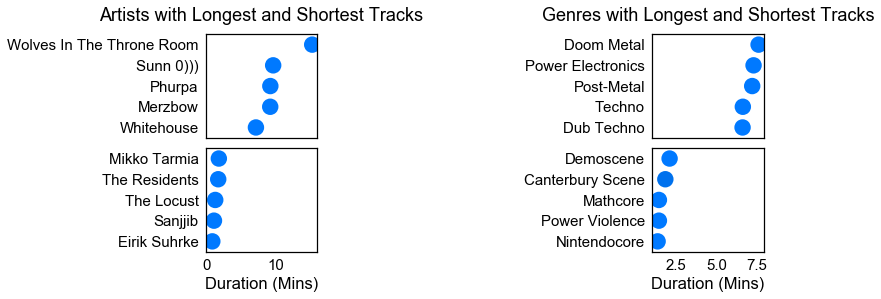

In [22]:
col = 'duration_mins'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, 
                         title='Artists with Longest and Shortest Tracks', 
                         xlabel='Duration (Mins)', axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, 
                        title='Genres with Longest and Shortest Tracks', 
                        xlabel='Duration (Mins)', axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

The longest tracks by far (on average) come from *Wolves in the Throne Room*, due to all of their tracks in my library being over 13 minutes long. The remaining bulk of long tracks comes from **Noise**, [**Doom Metal**](https://en.wikipedia.org/wiki/Doom_metal), and [**Drone**](https://en.wikipedia.org/wiki/Drone_music) artists.

The shortest tracks (on average) come from *Eirik Suhrke*. All of his tracks in my library are from the [Spelunky](https://en.wikipedia.org/wiki/Spelunky) soundtrack, which consists of *many* tracks, almost all of which are less than a minute long. Another notable artist &mdash; [*The Locust*](https://en.wikipedia.org/wiki/The_Locust) &mdash; is a band known for their very short tracks, typical of e.g. [**Grindcore**](https://en.wikipedia.org/wiki/Grindcore) acts.

---

Since hit songs with extremely long or short durations are atypical, let's have a look at the longest and shortest tracks in the Billboard dataset. First, the longest:

In [80]:
cols = ['name_artist', 'name', 'duration_mins']
df[df.ds=='top'].sort_values(by='duration_mins')[cols].tail()

,name_artist,name,duration_mins
9158,Sheila E.,The Glamorous Life,9.059333
9438,George Michael,I Want Your Sex - Pts. 1 & 2 Remastered,9.288217
8256,Tony! Toni! Toné!,Anniversary,9.397333
8498,Planet Soul,Set U Free - Fever Mix,9.832533
9322,Sheila E.,A Love Bizarre,12.300883


It would appear that these are mostly extended mixes of hit songs. How about the shortest hits?

In [79]:
cols = ['name_artist', 'name', 'duration_mins']
df[df.ds=='top'].sort_values(by='duration_mins')[cols].head()

,name_artist,name,duration_mins
6660,Rihanna,Birthday Cake,1.303333
10965,Maurice Williams & The Zodiacs,Stay - Remastered 2003,1.646217
10837,Herman's Hermits,"I'm Henry VIII, I Am",1.723100
10936,Burl Ives,Funny Way of Laughin’,1.739233
11035,Herb Alpert & The Tijuana Brass,A Walk In The Black Forest,1.810450


Most of these are simply short and to the point pop hits. 

One that stands out is *Rihanna*'s [*"Birthday Cake"*](https://www.youtube.com/watch?v=leK4eoqwmfU), which seems to fade out abruptly at about 1:15. From the song's [Wikipedia article](https://en.wikipedia.org/wiki/Birthday_Cake_(song)):

>After it leaked onto the internet, fans expressed interest in the track being included on Talk That Talk, but it was later revealed that the 1:18 (one minute, 18 seconds) length that leaked was in fact the final cut and was not being considered for inclusion on the album. Due to a high level of fan interest, the song was included on the album as an interlude.

---

Let's see how track duration has changed over the years.

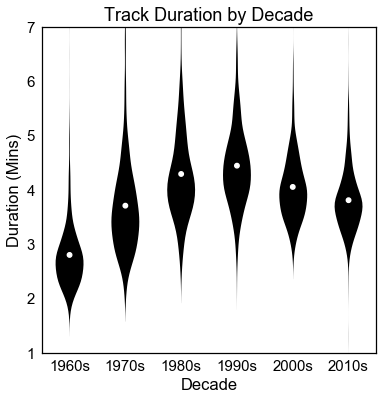

In [25]:
p = decade_violinplot( df, 'duration_mins', ylim=[1,7], 
                      title='Track Duration by Decade', 
                      ylabel='Duration (Mins)' )

Interesting! The average track duration seems to have risen and fallen over the decades, peaking in the 90s.

I suspected that limitations of physical media (e.g. vinyl records) could be one potential cause for such a pattern, so like any good modern researcher, I scoured the internet for answers.

Here are a few key points from the ["Music (single)" Wikipedia article](https://en.wikipedia.org/wiki/Single_(music)):

>Since the establishment of the Billboard Hot 100, **singles were not eligible to enter the chart unless they were available to purchase as a physical single**.

<!-- -->

>**The most common form of the vinyl single is the 45 or 7-inch.** The names are derived from its play speed, 45 rpm, and the standard diameter, 7 inches (18 cm).

<!-- -->

>Although 7 inches remained the standard size for vinyl singles, **12-inch singles were introduced for use by DJs in discos in the 1970s**. The longer playing time of these singles allowed the inclusion of extended dance mixes of tracks. 

The actual maximum duration of a single is determined by the disc diameter, rotation speed, and groove width. As quoted above, most vinyl singles have a diameter of 7 inches and a play speed of 45 rpm. The groove width can vary, but typically leads to a maximum single duration of roughly **3 minutes**. The later 12 inch single allowed for a track length of up to **15 minutes**, or even around **22 minutes** if designed for 33 rpm playback.

Starting in the 80s and 90s, all of this would eventually be phased out in favor of [CDs](https://en.wikipedia.org/wiki/CD_single), radio airplay, and ultimately digital downloads and streaming. These *essentially* removed any physical track duration limits. 

From the ["Compact disc" Wikipedia article](https://en.wikipedia.org/wiki/Compact_disc):

>After their **commercial release in 1982**, compact discs and their players were extremely popular. Despite costing up to &#36;1,000, over 400,000 CD players were sold in the United States between 1983 and 1984. **By 1988, CD sales in the United States surpassed those of vinyl LPs, and by 1992 CD sales surpassed those of prerecorded music cassette tapes.**

In summary, the upward trend in song durations can likely be (at least partially) attributed to a transition from 7 inch singles, to 12 inch singles (in the 70s), then CDs and digital (80s-present). However, this doesn't explain the downward trend since the 90s. 

We might naively expect longer and longer durations as physical limits are lifted, but there are clearly many other factors, such as: 
- The historical precedent set by past music, especially hit singles. 
- The innate tradeoff between airtime and revenue. 
- The attention span of streaming music consumers.
- Other, perhaps difficult-to-quantify social and musical trends.

A thorough cultural analysis of this phenomenon is beyond the scope of this project, so I'll leave it at that (for now).

**Note**: While collecting information about the history of hit singles, I stumbled upon a [Wired article](https://www.wired.com/2014/07/why-are-songs-on-the-radio-about-the-same-length/) that summarizes some similar results quite nicely. Note the interactive Plotly figure which shows the same nonlinear trend in song durations (post-1960), peaking in 1993.

---

Now, let's end the discussion of track durations by having a look at an artist who was *very* concerned with optimal song lengths.

## Wesley Willis' Song Durations

From Wesley Willis' [Wikipedia article](https://en.wikipedia.org/wiki/Wesley_Willis):

>Wesley Lawrence Willis (May 31, 1963 – August 21, 2003) was an American singer-songwriter and visual artist from Chicago. Diagnosed with schizophrenia in 1989, Willis began a career as an underground singer-songwriter in the outsider music tradition, with songs featuring his bizarre, humorous and often obscene lyrics sung over the auto accompaniment feature on his Technics KN keyboard. Willis gained a large cult following in the 1990s, particularly after the release of his 1995 Greatest Hits album on the Alternative Tentacles label.

It's said that Wesley was once advised that the ideal track length is 2 minutes and 50 seconds &mdash; advice which he followed religiously. From a [Tedium article](https://tedium.co/2017/11/16/wesley-willis-remembrance-history/):

>2:50.
The optimum length for a hit rock song, according to Wesley. The story goes that he once heard somebody say something to this effect, and the idea stuck in his head. A recording session in The Daddy of Rock and Roll shows him working with friend/engineer, Dale, trimming a few freshly recorded tunes to within three seconds of this time frame. Because of this effort in the studio, most of Wesley’s songs hover around the 2:50-2:52 mark.

Let's test this by plotting the distribution of Wesley Willis' tracks that are available on Spotify. We've already scraped the tracks in our [scraping notebook](spotify_1_scraping.ipynb), lets load the dataframe from its h5 file.

In [71]:
df_ww = pd.read_hdf('./data/df_ww.h5', 'main')

Now, we can visualize the distribution of Wesley Willis' track durations and compare them to our Billboard Hot 100 dataset.

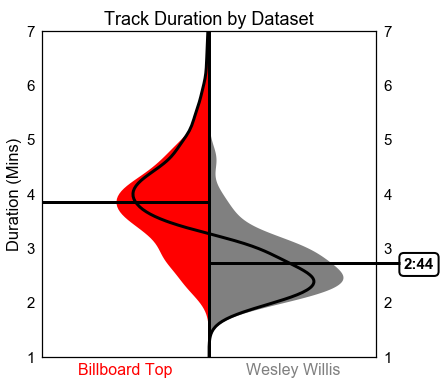

In [16]:
df_ww['ds'] = 'ww'
df_temp = df[df.ds=='top'].append(df_ww)

p = violin_midcurve( 'duration_mins', df_temp[df_temp.duration_mins<11],
                    y_label='Duration (Mins)', 
                    title='Track Duration by Dataset', 
                    hue_order=['top','ww'], ylim=[1,7], 
                    colors=[red,(.5,.5,.5)],
                    hue_labels=['Billboard Top','Wesley Willis'] )

#Calculate mean duration in df_ww, convert to mins:secs and turn into a string
mean = df_ww.duration_mins.mean()
mean_mins, mean_secs = np.round( divmod(mean*60,60) )
label = '{:d}:{:d}'.format( int(mean_mins), int(mean_secs) )

#Create a minor ytick and our ytick label at the mean value
p.set_yticks([mean], minor=True)
p.set_yticklabels( [label], minor=True, fontdict={'fontweight':'bold'} )

#Set length and width of tick, disable left ticks and ticklabels, 
#enable right ticks and ticklabels.
p.yaxis.set_tick_params(which='minor', size=24, width=3, right=True, 
                        labelright=True, left=False, labelleft=False)

#Pull out pointer to our ytick label and give it a rounded bounding box
yticklabel = p.yaxis.get_ticklabels(minor=True)[0]
yticklabel.set_bbox( dict(facecolor='none', edgecolor=(0,0,0), linewidth=2, 
                         boxstyle="round") )

Nice! It looks like Wesley's tracks were quite close to the magical **2:50** on average, with a tendency to undershoot. The actual distribution of hit song durations however peaks at around 4 minutes.

**Rock on, Wesley. ❤️**


# Loudness

From the Spotify API [documentation](https://developer.spotify.com/web-api/object-model/#audio-features-object):
>**loudness** (float): The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

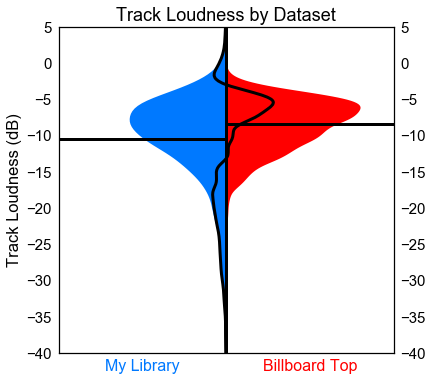

In [99]:
p = violin_midcurve( 'loudness', df, y_label='Track Loudness (dB)', 
                    ylim=[-40,5] )

As we've seen before, more extreme tracks are more likely to come from my library. Aside from that, the two distributions are rather similar.

Since decibels are logarithmic, we could try converting loudness to a linear "perceived loudness" ($L_p$) using a formula such as: 
$$L_p = 2^\frac{L}{10},$$
where $L$ is our `'loudness'` variable (in dB).

Or, in code:
`df['L_p'] = 2**( df['loudness']/10 )`

I leave this to the reader, as I've found it results in a very fat-tailed distribution that is difficult to visualize at any particular scale.

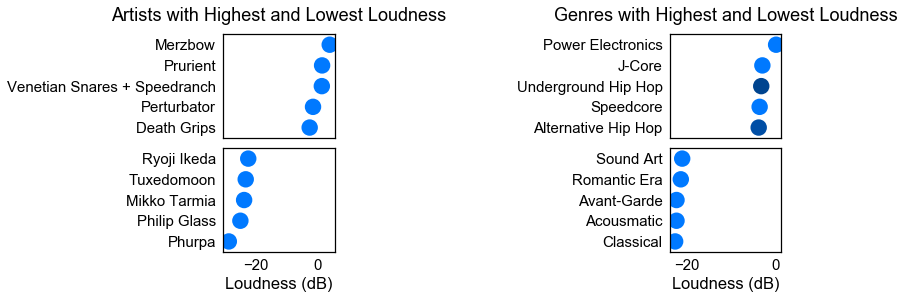

In [81]:
col = 'loudness'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, axes=(ax1,ax3), xlabel='Loudness (dB)')
p = extreme_genres_plot(by_genre, col, axes=(ax2,ax4), xlabel='Loudness (dB)')
plt.subplots_adjust(wspace=3)

Again, the extremes come from my library; Both the loudest (e.g. **Harsh Noise**, [**Breakcore**](https://en.wikipedia.org/wiki/Breakcore), and [**Power Electronics**](https://en.wikipedia.org/wiki/Power_electronics_(music%29)  acts) and the softest (e.g. **Drone**, **Classical**, and [**Sound Art**](https://en.wikipedia.org/wiki/Sound_art)).

Let's see how loudness has changed over time.

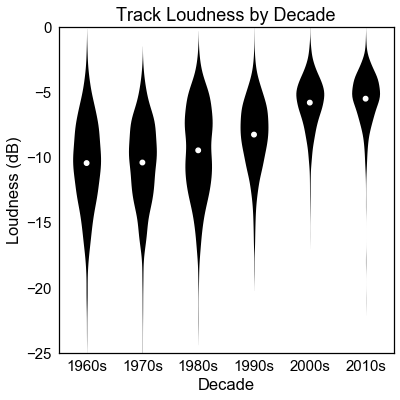

In [21]:
p = decade_violinplot( df, 'loudness', ylim=[-25,0], ylabel='Loudness (dB)' )

Here, we can clearly see what is sometimes called the "loudness war." From the [Wikipedia article](https://en.wikipedia.org/wiki/Loudness_war):

>The loudness war (or loudness race) refers to the trend of increasing audio levels in recorded music which many critics believe reduces sound quality and listener enjoyment.

While this trend in increasing loudness began before the compact disc, the loudness war was largely made possible by digital signal processing techniques that were not possible prior to compact discs:

>With the advent of the Compact Disc (CD), music is encoded to a digital format with a clearly defined maximum peak amplitude. Once the maximum amplitude of a CD is reached, loudness can be increased still further through signal processing techniques such as dynamic range compression and equalization. Engineers can apply an increasingly high ratio of compression to a recording until it more frequently peaks at the maximum amplitude.

In the above plot, we can see the very first hints of a loudness war in the 1980s, coinciding with the gradual adoption of CDs through the decade:

>Since CDs were not the primary medium for popular music until the **late** 1980s, there was little motivation for competitive loudness practices then.

We see the average loudness increase significantly in the 90s, due to the development of new CD mastering techniques:

>By the early 1990s, mastering engineers had learned how to optimize for the CD medium and the loudness war had not yet begun in earnest. However, in the early 1990s, CDs with louder music levels began to surface, and CD levels became more and more likely to bump up to the digital limit, resulting in recordings where the peaks on an average rock or beat-heavy pop CD hovered near 0 dB, but only occasionally reached it.

The largest increase in loudness appears in the 2000s, at which point the loudness war was in full effect. This was brought into public awareness by the controversy surrounding Metallica's 2008 album, *Death Magnetic.*

>The CD version of the album has a high average loudness that pushes peaks beyond the point of digital clipping, causing distortion. This was reported by customers and music industry professionals, and covered in multiple international publications, including Rolling Stone, The Wall Street Journal, BBC Radio, Wired, and The Guardian.

The average track loudness has since plateaued at around -5.6 dB through the 2000s and 2010s.

# Tempo

From the Spotify API [documentation](https://developer.spotify.com/web-api/object-model/#audio-features-object):

>**tempo** (float): The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

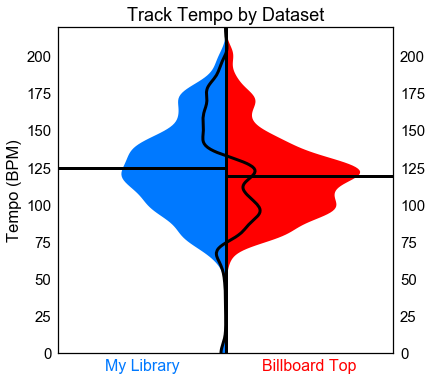

In [88]:
p = violin_midcurve( 'tempo', df, y_label='Tempo (BPM)', ylim=[0,220] )

Again, we see more extreme tracks in my library, with similar means across datasets.

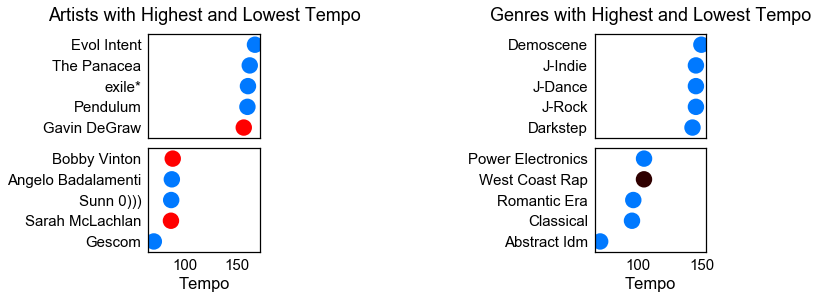

In [28]:
col = 'tempo'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

The fastest tracks in the datasets come from [**Drum and Bass**](https://en.wikipedia.org/wiki/Drum_and_bass) and **Breakcore** artists, as well as various genres (**J-Indie**, **J-Dance**, **J-Rock**) associated with the Japanese new wave band [Polysics](https://en.wikipedia.org/wiki/Polysics). 

The fastest genre appears to be [**Demoscene**](https://en.wikipedia.org/wiki/Demoscene) music, but this seems to be due to a large number of tracks by chiptune artist [Beek](https://b-e-e-k.bandcamp.com/) some of which *might* be mislabeled as having twice their actual tempo. More on this soon.

The slowest tracks are mostly Drone, Ambient, and Classical. Gescom (and the corresponding **Abstract IDM** genre has a particularly low average BPM due to a large number (35) of 0 BPM tracks on their [*Minidisc*](https://en.wikipedia.org/wiki/Minidisc_(album%29) album:

In [122]:
df[ (df.name_artist=='Gescom') & (df.tempo==0) ].name_album.value_counts()

Mini Disc    35
Name: name_album, dtype: int64

---

Before over-interpreting the `'tempo'` variable, lets investigate a problem inherent to tempo detection.

## The Octave Error Problem

When attempting to detect a track's tempo automatically (or even by ear) it is common to detect a tempo that is a factor of 2 faster (or slower) than the musician's intended tempo. For example, a 120 BPM track may be "mislabeled" as having a tempo of 60 or 240 BPM.

*Note: I avoid referring to a "true" tempo, since it is often the case that there is no single true tempo for a given track. Ultimately, the notion of tempo is sometimes quite subjective, particularly when the music in question is complex.*

This problem is commonly called the "octave error" problem. Typically, "[octave](https://en.wikipedia.org/wiki/Octave)" refers to a pair of musical pitches where one has twice the frequency of the other. The analogous tempo octave refers to two tempi, one of which is twice the BPM of the other.

From [*FAST vs SLOW: LEARNING TEMPO OCTAVES FROM USER DATA*](http://www.music.mcgill.ca/~hockman/projects/fastSlow/Fast_v_Slow.pdf):

>The most frequent error in this context is the so-called octave error, or the halving or doubling of the perceived tempo caused by attributing the driving beat level to a metrical level other than the most predominant pulse.
Identification of the most appropriate tempo octave has
been shown to be a difficult problem, as demonstrated
in the discrepancy between beat tracking evaluations in
which a single tempo octave and multiple tempo octaves
are accepted.

Rather than attempting to "correct" the "mislabeled" tempi in my dataset, I'll take a different, nearly opposite approach. Instead of trying to distinguish between tempi that are an octave apart (e.g. 60, 120, or 240 BPM), let's simply treat them all as having the same "octave-wrapped" tempo. *This dodges the octave error problem, and gives us arguably **better statistics** (more tracks per tempo).*

## Octave-Wrapped Tempo

If we think of tempo as existing on a line, from low to high tempo, we essentially want to "wrap" this line around a *circle*, much like how linear time is represented cyclically on an 12-hour mechanical clock. On such a clock, times that are **integer multiples of 12 hours** apart (e.g. Tuesday, 6:35 AM and Friday, 6:35 PM) are treated as identical. In our case, we'll wrap the tempos so that when two tempi are an **integer number of octaves** apart, they will be treated as identical.

While searching the internet for a similar approach, I stumbled upon a [drum lessons site](http://www.playdrumsnow.com/) that provides a so-called ["Tempo Spiral"](http://www.playdrumsnow.com/tempo-spiral/) to assist drummers when practicing. This tempo spiral (shown below) also serves as a visualization of octave-wrapped tempo as I've described it, with tempi spiraling out in such a way that tempo octaves line up.

![Image of Tempo Spiral](figures/tempo_spiral.png)

Mathematically, this transformation can be performed by applying the modulus operator to the logarithm (base 2) of the tempo. This will result in a number between 0 and 1 that represents our octave-wrapped tempo. To make this value more interpretable, we can map this number back to a range of *representative* tempi that range from some minimum tempo (`tempo_min`) to twice that minimum tempo. So, we have:

$$\log_2\left( \frac{T_\text{wrapped}}{T_\text{min}} \right) = \log_2\left(\frac{T}{T_\text{min}}\right) (\bmod 1), $$

where $T_\text{wrapped}$ is the octave-wrapped tempo, $T$ is our original tempo, and $T_\text{min}$ is our minimum tempo, `tempo_min`. Of course we can solve for $T_\text{wrapped}$ by raising both sides to the power of $2$ and multiplying both sides by $T_\text{min}$, but this form avoids cluttered superscripts.

In Python, we have:

`tempo_wrapped = ( 2**( np.log2( tempo/tempo_min )%1 ) )*tempo_min`

---

If this implementation is confusing, consider an equivalent algorithm:
1. Define a minimum representative tempo `tempo_min`, and a maximum representative tempo that is exactly twice that of `tempo_min`.
2. If a track's tempo is already *between these two tempi*, **leave it unchanged**. If the track's tempo is *greater than the maximum tempo*, **repeatedly divide the tempo by 2** until it falls within the acceptable range of representative tempi. Similarly, if a track's tempo is *less than the minimum tempo*, **repeatedly multiply the tempo by 2** until it falls within the acceptable range.

Regardless of the implementation, the result is a mapping from tempi to a range of representative octave-wrapped tempi that "wrap around" to `tempo_min` whenever the maximum representative tempo is exceeded.

The choice of `tempo_min` is arbitrary. Below, we chose a default value that gives a nice range of representative tempi (68 to 136 BPM).

In [148]:
def wrap_tempo(tempo, tempo_min=68):
    #Map tempo to a circle such that tempo octaves line up.
    tempo_wrapped = ( 2**( np.log2(tempo/tempo_min)%1 ) )*tempo_min

    return tempo_wrapped

Let's try it on various tempi:

In [152]:
df_temp = pd.DataFrame( { 'tempo' : [60, 120, 240, 45, 128.69, 9456, 0] } )
df_temp['tempo_wrapped'] = df_temp.tempo.apply(wrap_tempo)
df_temp

,tempo,tempo_wrapped
0,60.00,120.000
1,120.00,120.000
2,240.00,120.000
3,45.00,90.000
4,128.69,128.690
5,9456.00,73.875
6,0.00,NaN


Looks good! Notice that 0 BPM is mapped to `NaN`, since it has no well-defined octave-wrapped tempo.

Let's apply it to our dataframe, creating a new `'tempo_wrapped'` column.

In [153]:
df['tempo_wrapped'] = df['tempo'].transform(wrap_tempo)

Now, we can visualize the distribution of octave-wrapped tempi using a polar histogram!

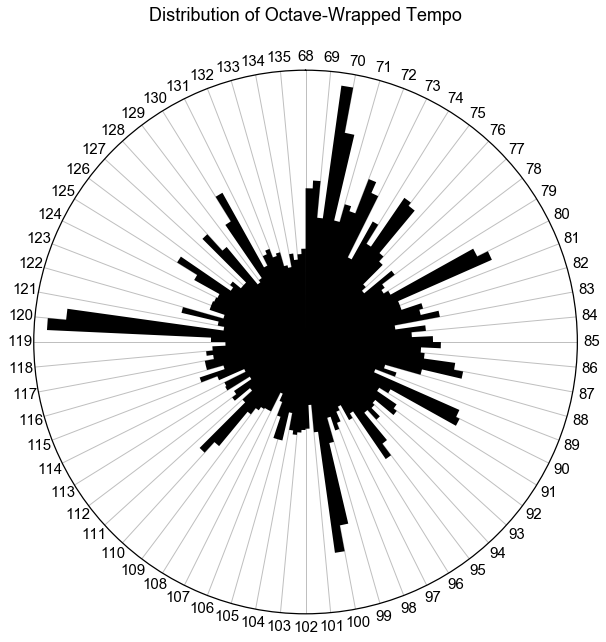

In [163]:
ax1 = plt.subplot(111, polar=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)

#Create and set our tempo labels and ticks
ticklabels = np.arange(68,137,1)
ticks = np.linspace(0,68,68, endpoint=False)
ticks_rad = ticks*2*np.pi/68
ax1.set_xticks(ticks_rad)
ax1.set_xticklabels(ticklabels)
ax1.xaxis.grid(False, which='major', color=(0,0,0), alpha=0.25)
ax1.set_yticks([])

#We'll draw the histogram clockwise, starting at the top (like a clock!)
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location('N')

#Plot the histogram, add title.
plt.hist( ( df.tempo_wrapped.dropna()-68 )*2*np.pi/68, bins=136, color='black', 
         histtype='stepfilled')
plt.title('Distribution of Octave-Wrapped Tempo');
ax1.title.set_position([.5, 1.08])

We can immediately see many sharp peaks at **multiples of 10 BPM**. While I found no definitive explanation for this phenomenon, it seems likely that the human tendency to favor "simple," [round numbers](https://en.wikipedia.org/wiki/Round_number) would be a major contributor. This combined with the heavy use of programmable drum machines, sequencers, and click tracks with precise BPM settings could explain such sharp peaks. A finite number of simple tempi also makes for easier [beatmatching](https://en.wikipedia.org/wiki/Beatmatching) of tracks by DJs, but how much this might influence non-dance music is unclear. Finally, it's possible that the tempo detection algorithm is slightly biased towards detecting multiple-of-ten tempi, but our analysis across decades (below) will suggest otherwise.

We also see smaller peaks at multiples of 5 BPM, which may be at least partly due to *fast* multiple-of-ten tempi that were mapped to a half-speed octave-wrapped tempo (e.g. 150 BPM mapped to 75 BPM).

---

The largest peak is at **120 BPM**. One simple explanation for this is that, among the already popular multiple-of-ten tempi, it may be the closest to a "sweet spot" of pace and danceability for most humans. 120 BPM is also exactly *two beats per second*. Since seconds are such a deeply ingrained unit of time for modern humans, it's unsurprising that the pace of music would line up so well with seconds. One beat per second is probably too slow, but two is "just right," while being a very simple multiple. This is reinforced by the ubiquity of the ticking clock, which may have even been sometimes used as a metronome, especially before the use of modern techniques. 

This focus on 120 BPM was particularly prevalent in 70s disco and later, related dance music. This prevalence caused most music software and hardware of the 80s and 90s to use a default tempo of 120 BPM, thus further reinforcing this tendency. Currently, **nearly *all* music software and hardware defaults to 120 BPM**.

---

Let's see how the tempi of Billboard hits have changed over the decades!

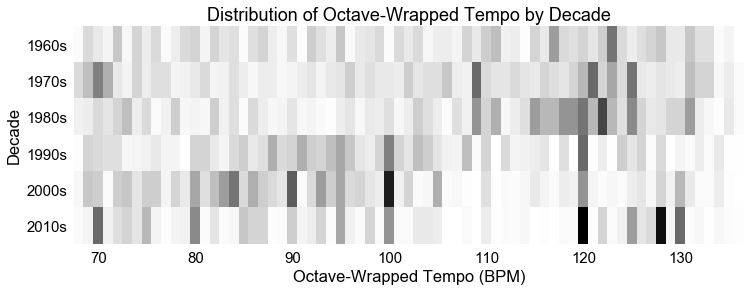

In [170]:
#Round the tempi to the nearest integer
tempo_wrapped_rounded = df.tempo_wrapped.round()

#Create a pivot table of these tempi, to use in a heatmap
df_tempo_decade = df.pivot_table(values='id', columns=tempo_wrapped_rounded, 
                                 index='decade', aggfunc=np.count_nonzero)

#Custom gamma-adjusted grayscale colormap
cm_list = [ ( 0, (1,1,1) ), ( 1, (0,0,0) ) ]
cm = mpl.colors.LinearSegmentedColormap.from_list('mymap', cm_list, N=256, 
                                                  gamma=2.0)

#Make heatmap, add x/y labels
plt.figure(figsize=(12,4))
sns.heatmap(df_tempo_decade, cmap=cm, square=False, cbar=False);
plt.xlabel('Octave-Wrapped Tempo (BPM)')
plt.ylabel('Decade')

#Decade ticklabels
ax = plt.gca()
ax.set_yticklabels(['1960s', '1970s', '1980s', '1990s', '2000s', '2010s'], 
                   rotation='horizontal')

#Convert x labels to integers, and only label multiples of 10 to avoid clutter
xlabels = [ item.get_text() for item in ax.get_xticklabels() ]
xlabels = [ int( float( label ) ) for label in xlabels ]
xlabels = [ str(x) if x%10==0 else '' for x in xlabels ]
ax.set_xticklabels(xlabels, rotation='horizontal')

plt.title('Distribution of Octave-Wrapped Tempo by Decade');

The first thing to observe is that the distribution becomes more "peaked" over time. If our above explanation of these (primarily multiple-of-ten) peaks is valid, it makes sense that they would emerge and sharpen as music technology develops. For example, we can see a large number of songs that are near the "sweet spot" of 120 BPM in the 80s, which suddenly concentrates to a peak at precisely 120 BPM in the 90s. This might correspond to the mainstream adoption of drum machines and related music technology in the late-80s and 90s.

These peaks persist and strengthen as we move from the 90s to the 2000s, where 100 BPM and 90 BPM seems to be more popular than 120 BPM, reflecting a temporary tendency towards slower hits. The peaks are the sharpest yet in the 2010s, and 120 BPM again dominates, but we also see a strange, new peak at **128 BPM**. This may be due to the fact that $128$ is a *power of two* ($128=2^7$), which makes it easy to divide musical patterns in half repeatedly (common when aligning and combining multiple musical patterns in software). This notion of divisibility might also be another reason for the popularity of 120 BPM, as 120 is divisible by many different numbers. In fact, $120$ is [anti-prime](https://en.wikipedia.org/wiki/Highly_composite_number).

---

To close out our discussion of multiple-of-ten tempi, let's directly plot the distribution of the last digit of our tracks' tempi.

In [186]:
#"Wrap" every 10 BPM to give the tempo's final digit, e.g. 134 BPM --> 4
df['tempo_lastdigit'] = df['tempo']%10

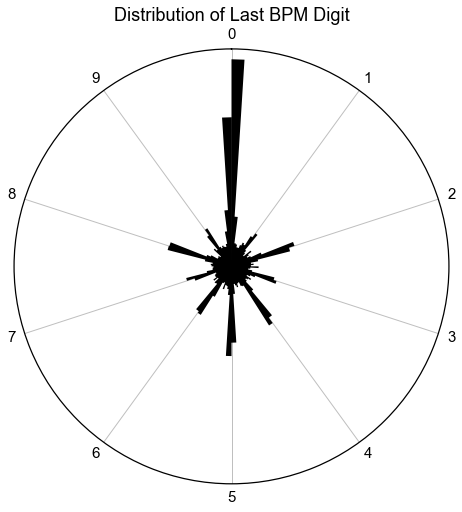

In [188]:
#Set up figure, radial ticks, and labels
ax1 = plt.subplot(111, polar=True)
fig = plt.gcf()
fig.set_size_inches(8, 8)
ticks = np.arange(0,10)
ticks_rad = ticks*2*np.pi/10
ax1.set_xticks(ticks_rad)
ax1.set_xticklabels(ticks)
ax1.xaxis.grid(False, which='major', color=(0,0,0), linewidth=1, alpha=0.25)
ax1.set_yticks([])

#Clockwise, starting at the top ('North')
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location('N')

#Plot and add title
plt.hist( df.tempo_lastdigit.dropna()*2*np.pi/10, bins=100, color='black', 
         histtype='stepfilled')
plt.title('Distribution of Last BPM Digit');

This makes the bias towards multiple-of-ten tempi even clearer than before. We can also clearly see the second-largest peak at multiples of 5. In addition, the tempos are clearly biased to have an **integer** BPM. This can again be attributed to a human tendency to favor round numbers, a tendency that is strongly encouraged by modern music software and hardware. In fact, modern music software and hardware can sometimes make it quite difficult or even *impossible* to use non-integer tempi.

---

Let's see how the last digit of our tracks' tempi has changed over the decades.

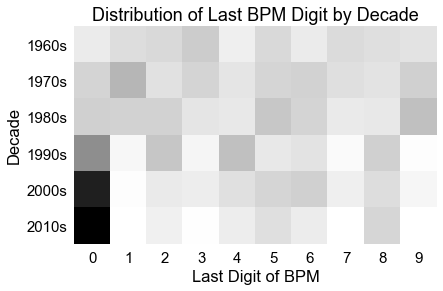

In [189]:
#Should technically round this *prior* to applying modulus operator,
#but this gives the same result in our case.
tempo_lastdigit_rounded = df.tempo_lastdigit.round()%10

#Create pivot table for heatmap
df_tempo_lastdigit_decade = df.pivot_table(values='id', index='decade', 
                                     columns=tempo_lastdigit_rounded, 
                                     aggfunc=np.count_nonzero)

#Make heatmap, add x/y labels
plt.figure(figsize=(8,4))
sns.heatmap(df_tempo_lastdigit_decade, cmap=cm, square=True, cbar=False);
plt.xlabel('Last Digit of BPM')
plt.ylabel('Decade')

#Decade ticklabels
ax = plt.gca()
ax.set_yticklabels(['1960s', '1970s', '1980s', '1990s', '2000s', '2010s'], 
                   rotation='horizontal')

#Convert x labels to integers
xlabels = [ item.get_text() for item in ax.get_xticklabels() ]
xlabels = [ int( float( label ) ) for label in xlabels ]
xlabels = [ str(x) for x in xlabels ]
ax.set_xticklabels(xlabels, rotation='horizontal')

plt.title('Distribution of Last BPM Digit by Decade');

Again we see the formation of a peak at multiple-of-ten tempi starting in the 90s, and strenghtening through the 2000s and 2010s. Not at all surprising given our above analysis, but this is the clearest visualization of this phenomenon yet!

Let's move on to `'mode'` and `'time_signature'`

# Mode and Time Signature

From the Spotify API [documentation](https://developer.spotify.com/web-api/object-model/#audio-features-object):
>**mode** (int): Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

>**time_signature** (int): An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

Since these variables are discrete (integers) we need to quickly define a new plot that's analogous to our (continuous-variable) `violin_midcurve` plot. We again construct a function, as we'll use this plot in later notebooks as well.

## Bar-Violin Plot

In [194]:
# %%writefile bar_violin.py
# #Imports here for writefile magic only. Not Pythonic.
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# red = (1,0,0)
# blue = (0,.475,1) #Same relative luminance as primary red (approx)

def bar_violin(y, data, hue='ds', y_label=None, colors = [blue, red],
               hue_labels=['My Library','Billboard Top'], order=None, 
               hue_order=['nix','top'], ax=None, int_labels=False, title=None):

    #Assumes binary variable with no missing values
    split_vals = data[hue].unique()
        
    #Count non-missing values for both sets, to normalize each barplot
    totals = ( data[y][ data[hue]==split_vals[0] ].count(), 
              data[y][ data[hue]==split_vals[1] ].count() )
    
    #Construct left and right barplots 
    #Note the negative values trick in the first (left) plot
    p = sns.barplot(x='', y=y, data=data[ data[hue]==split_vals[0] ], 
                    estimator=lambda x: -len(x)/totals[0], orient='h', ci=None,
                    color=colors[0], saturation=1, ax=ax )
    p = sns.barplot(x='', y=y, data=data[ data[hue]==split_vals[1] ], 
                    estimator=lambda x: len(x)/totals[1], orient='h', ci=None, 
                    color=colors[1], saturation=1, ax=ax )

    #Center the plot
    xlim = p.get_xlim()
    xlim_max = max( np.abs( xlim ) )
    p.set_xlim( [-xlim_max, xlim_max] )

    #Plot vertical line
    ylim = p.get_ylim()
    p.plot( [0]*2, ylim, 'k-', lw=1.5)

    #Custom Y axis label
    if y_label is None:
        y_label = y.title() #Capitalize first letter
    p.set_ylabel(y_label)
        
    #Title, with default.
    if title is None:
        var = y.title() #Capitalize first letter
        title = 'Track ' + var + ' by Dataset'
    p.set_title(title)

    #This is necessary, othewise the ticklabels will not be populated 
    #until the entire cell has completed
    #Quirk of %matplotlib inline
    plt.draw() 

    #Remove x tick labels
    p.set_xticklabels([])

    #Integer formatting for y axis
    if int_labels:
        ylabels = [ item.get_text() for item in p.get_yticklabels() ]
        ylabels = [ str( int( float( label ) ) ) for label in ylabels ]
        p.set_yticklabels(ylabels);
     
    #Add redundant y axis
    p.tick_params(labelright=True)

    #Add colored split variable indicators to bottom of frame
    p.text(.25, -.04, hue_labels[0], horizontalalignment='center', 
           verticalalignment='center', transform = p.transAxes, 
           color=colors[0], size=16)
    p.text(.75, -.04, hue_labels[1], horizontalalignment='center', 
           verticalalignment='center', transform = p.transAxes, 
           color=colors[1], size=16)

    return p

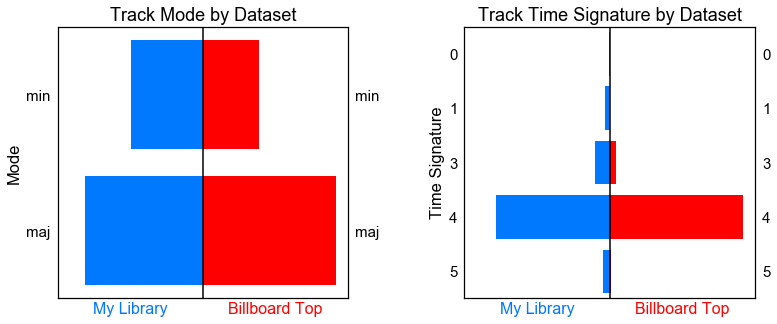

In [195]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12.5,5))
p = bar_violin('mode', df, int_labels=True, ax=ax1 )
ax1.set_yticklabels(['min','maj'])
p = bar_violin('time_signature', df, y_label='Time Signature', 
               title='Track Time Signature by Dataset', int_labels=True, 
               ax=ax2 )
plt.subplots_adjust(wspace=.4)

We see the same number of major mode tracks in both datasets, and slightly more minor tracks in mine. `'mode'` would not be a terribly useful dataset predictor. 

Focusing on time signatures, we see that most tracks (in both datasets) are the standard $4\atop4$ time. The "weirdest" time signatures are $5\atop4$ and "$1$," the latter of which I assume represents an unknown or not-well-defined time signature. In both cases, these uncommon time signatures are almost exclusively found in my dataset. Unfortunately, the rarity (in *both* datasets) of tracks with uncommon time signatures still makes them a poor dataset predictor in terms of pure accuracy.

Let's have a look at the most popular tracks with an ill-defined time signature (`'time_signature'=1`)

In [199]:
cols = ['name', 'name_artist', 'time_signature', 'popularity', 'ds']
df[df.time_signature==1].sort_values('popularity', 
                                     ascending=False)[cols].head(10)

,name,name_artist,time_signature,popularity,ds
235,Them Bones,Alice In Chains,1.0,62,nix
8282,Now And Forever,Richard Marx,1.0,59,top
10815,Blue Velvet,Bobby Vinton,1.0,59,top
7332,Say Yes,Floetry,1.0,50,top
8596,"My Heart Will Go On - Love Theme from ""Titanic""",Céline Dion,1.0,50,top
3864,March Of The Pigs,Nine Inch Nails,1.0,47,nix
11063,Greenfields,The Brothers Four,1.0,43,top
936,Dawn Chorus,Boards of Canada,1.0,41,nix
981,Collapse,Boards of Canada,1.0,38,nix
5122,Reborn,Slayer,1.0,37,nix


Most of these are actually in standard $4\atop4$ time! As with tempo, detecting time signature can be very tricky, so it's unsurprising to see errors such as this. 

Of the remaining tracks, *Them Bones* is in $7\atop8$, *Greenfields* is in $12\atop8$ (or a "swingy" $4\atop4$), and *Collapse* is something like $10\atop8$. *[March of the Pigs](https://www.youtube.com/watch?v=6mDQNRs5JCs)* has a verse that repeats three $7\atop8$ bars followed by an $8\atop8$ bar, and the chorus is in $4\atop4$. 

*[Say Yes](https://www.youtube.com/watch?v=PCCGIXME164)* is in $4\atop4$ time, but has an interesting groove that could likely throw off time signature detection.

---

Let's see which artists and genres use the most use of uncommon time signatures!

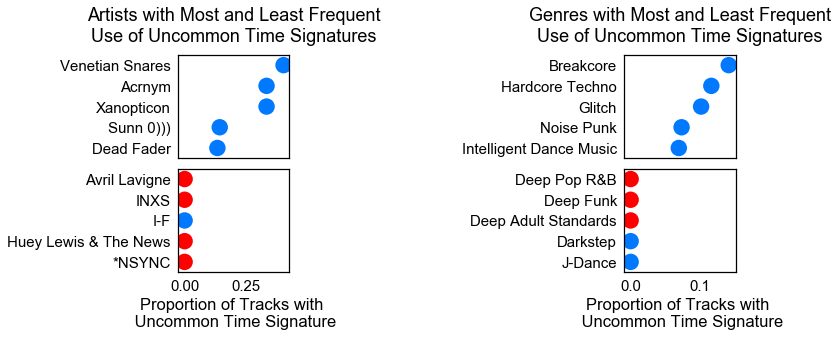

In [182]:
#Make new 'uncommon_timesig' variable, and by_genre grouping
df_temp = df[['name_artist','genres','ds']].copy()
df_temp['uncommon_timesig'] = (df['time_signature']==1)
by_genre_temp = groupby_lists(df_temp, 'genres', 'genre')

#Pass this directly into our extremes plots.
col = 'uncommon_timesig'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
artists_title = """Artists with Most and Least Frequent
Use of Uncommon Time Signatures"""
artists_xlabel = 'Proportion of Tracks with \n Uncommon Time Signature'
p = extreme_artists_plot(df_temp, col, axes=(ax1,ax3), min_tracks=6, 
                         title=artists_title, xlabel=artists_xlabel,)
genres_title = """Genres with Most and Least Frequent
Use of Uncommon Time Signatures"""
genres_xlabel = 'Proportion of Tracks with \n Uncommon Time Signature'
p = extreme_genres_plot(by_genre_temp, col, axes=(ax2,ax4),
                       title=genres_title, xlabel=artists_xlabel)
plt.subplots_adjust(wspace=3)

Since common time signatures are so prevalent in both datasets, most artists and genres have close to **zero** tracks with an uncommon time signatures. Therefore, there's nothing particularly unique about the artists and genres on the bottom of our plots.

All of the artists and genres associated with heavy use of uncommon time signatures come from my library. The three that stand out the most are [Venetian Snares](https://en.wikipedia.org/wiki/Venetian_Snares), [Acrnym](https://acrnym.bandcamp.com/), and [Xanopticon](https://xanopticon.bandcamp.com/), all three of which are **Breakcore** artists that utilize atypical time signatures. Venetian Snares in particular has a strong tendency to produce tracks in $7\atop8$ time, and Acrnym is known to have been heavily influenced by Venetian Snares, utilizing similar time signatures. Almost all of the genres in the top of our plot are associated with these three artists.

# Energy, Liveness, Danceability, and Speechiness

For the sake of completeness, I include plots of `'energy'`, `'liveness'`, `'danceability'`, and `'speechiness'` without further analysis.

From the Spotify API [documentation](https://developer.spotify.com/web-api/object-model/#audio-features-object):

>**energy** (float): Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

>**liveness** (float): Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

>**danceability** (float): Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

>**speechiness** (float): Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

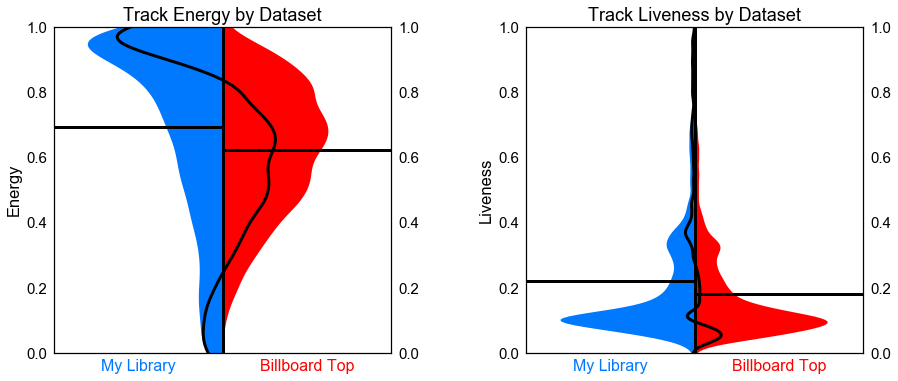

In [85]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
p = violin_midcurve( 'energy', df, ylim=[0,1], ax=ax1 )
p = violin_midcurve( 'liveness', df, ylim=[0,1], ax=ax2, bw=.1 )
plt.subplots_adjust(wspace=.4)

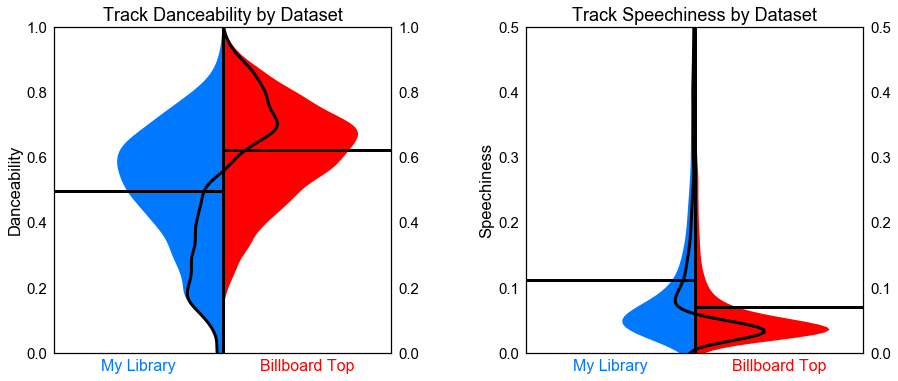

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
p = violin_midcurve( 'danceability', df, ylim=[0,1], ax=ax1 )
p = violin_midcurve( 'speechiness', df, ylim=[0,0.5], ax=ax2 )
plt.subplots_adjust(wspace=.4)

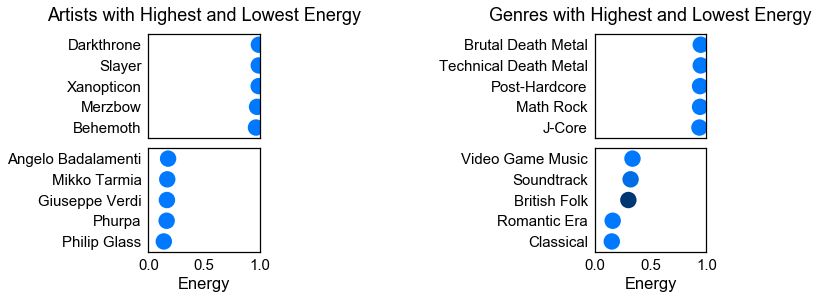

In [21]:
col = 'energy'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, xlim=[0,1], axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, xlim=[0,1], axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

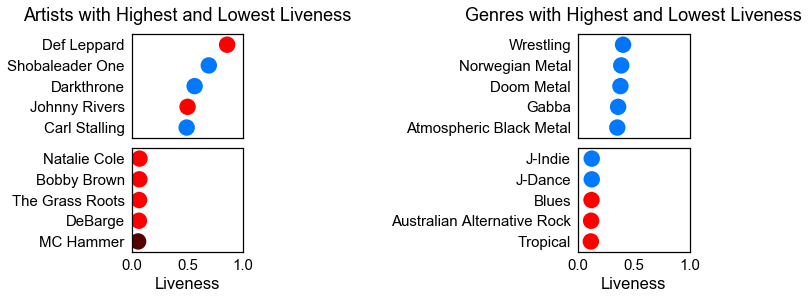

In [27]:
col = 'liveness'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, xlim=[0,1], axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, xlim=[0,1], axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

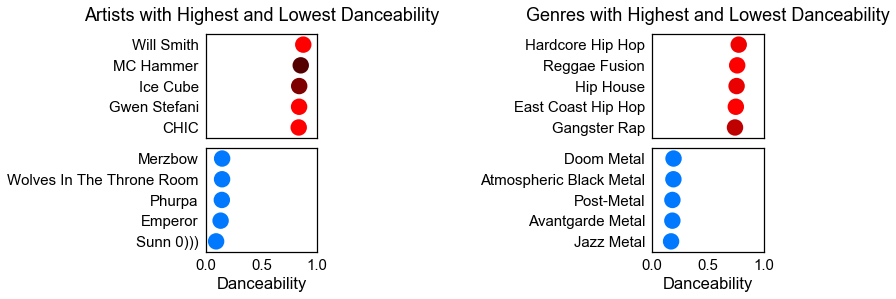

In [14]:
col = 'danceability'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, xlim=[0,1], axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, xlim=[0,1], axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

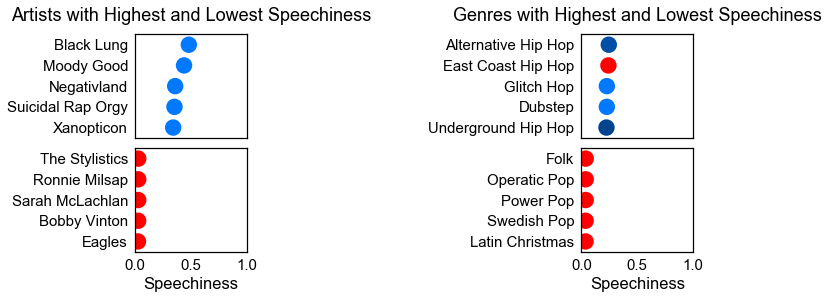

In [15]:
col = 'speechiness'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
p = extreme_artists_plot(df, col, xlim=[0,1], axes=(ax1,ax3))
p = extreme_genres_plot(by_genre, col, xlim=[0,1], axes=(ax2,ax4))
plt.subplots_adjust(wspace=3)

# Interactions between Audio Features

To finish up our exploration of Spotify's audio features. Let's have a brief look at how some of the features are related to each other.

## Bivariate Spikeplot (Scatterplot)

When visualizing interactions between two continuous variables, there are many options including scatter plots, histograms (square or hexagonal), and smooth (e.g. KDE) density plots. 

Standard scatter plots have the benefit of showing each individual datapoint, but poorly represent overlapping datapoints. High density regions may be drawn as a solid color, hiding the possible variation of density in said regions. Similarly, if many datapoints have nearly identical values, they may be shown as a single point in the scatter plot.

Histograms can display the actual density of datapoints in a region, but the binning imposes (sometimes desirable) artificial boundaries. Smooth density estimates avoid this, but may still require tuning of a smoothing parameter. Both histograms and smooth density estimates have implicit modeling assumptions associated with them, and are thus arguably a bit more removed from the data than a standard scatter plot. They also fail to show individual datapoints (e.g. outliers), which might be useful to visualize.

---

One compromise is what I've seen called a "spike plot," which is a virtually "unsmoothed" density estimate. This could be a e.g. histogram (square or hexagonal) with very narrow bins (a few pixels wide), or a KDE with a very small bandwidth. In both cases, the result is a density estimate that looks roughly like a scatter plot, with the ability to also show both individual outliers and density of overlapping points.

I've experimented with creating a number of different spike plot implementations, using kernel density estimation (very slow, but pretty!), and hex-binned histograms (faster, some visual artifacts from the binning). Ultimately, the simplest solution was the tried-and-true method of a standard *scatter plot with alpha-blended datapoints*. This is in some ways less theoretically justified than a "proper" density estimate (e.g. alpha blending doesn't "add up" quite like probability density), but my modified scatter plot below gives very similar visual results to my kernel density estimation implementation.

---

The function `smooth_scatterplot` creates a 2d alpha-blended scatter plot based upon matplotlib's `scatter`. The datapoints are optionally colored red or blue, according to which dataset they come from. 

Since the *order* in which colored, alpha-blended datapoints are drawn affects the final color (another quirk of alpha blending), we shuffle the datapoints before drawing. This prevents e.g. all of the red datapoints being draw after the blue datapoints.

Dense, alpha-blended scatterplots tend to have ugly artifacts due to how sharp-edged markers overlap. We approximate smooth markers by drawing 5 copies of each marker, decreasing in size, and alpha blending them. Hence the name "`smooth_scatterplot`".

Since the goal here is to have a *useful visualization* (rather than, say, an objective density estimate) the alpha blending (`alpha`) can (and *should*) be tweaked by hand.

In [3]:
# %%writefile smooth_scatterplot.py
# #Imports here for writefile magic only. Not Pythonic.
# import seaborn as sns
# import matplotlib.pyplot as plt

def smooth_scatterplot(data, xcol, ycol, color=True, alpha=.03, size=1, 
                       ax=None, xlabel=None, ylabel=None, title=None):
    """Generates a simple scatter plot with blurred markers 
    and alpha blended colors."""
    
    if ax is None:
        ax = plt.gca()
    
    #Shuffle rows so different colored points are layered at random
    df_temp = data[ [xcol, ycol, 'ds'] ].dropna().sample(frac=1)

    #Color via dataset: 'nix'=blue, 'top'=red.
    df_temp['color'] = df_temp.ds.map( { 'nix':blue, 'top':red } )
    
    #Base size
    s0 = size
    
    #Color or grayscale?
    if color:
        c=df_temp.color
    else:
        c = (0,0,0)
    
    #Build up "smooth" markers
    for i in reversed( range(5) ):
        #Marker size
        s=(s0*(i+1))**2
        ax.scatter(df_temp[xcol], df_temp[ycol], c=c, s=s, alpha=alpha,
                        linewidths=0)
    
    #Add labels and title
    if xlabel is None:
        xlabel = xcol.title()
    if ylabel is None:
        ylabel = ycol.title()
    if title is None:
        title = xcol.title() + ' vs. ' + ycol.title()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    return ax

Let's use our new plot to see how a track's danceability is affected by its energy and tempo!

## The Effect of Energy and Tempo on Danceability

First, in grayscale (`color=False`):

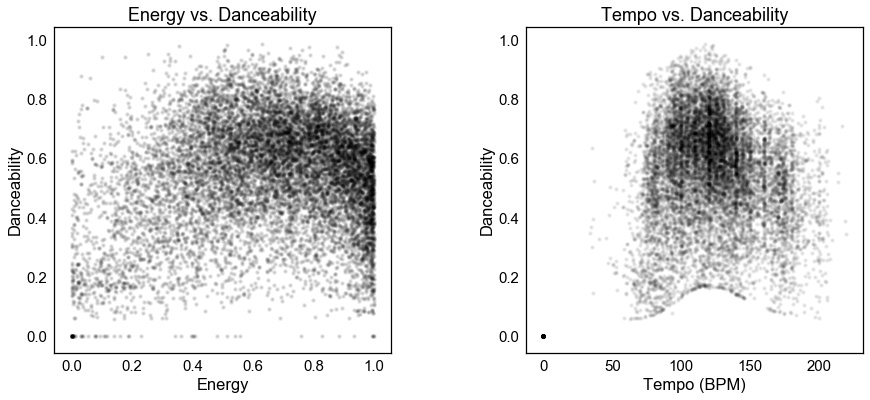

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
p = smooth_scatterplot(df, 'energy', 'danceability', color=False, alpha=.05, 
                       ax=ax1)
p = smooth_scatterplot(df, 'tempo', 'danceability', color=False, alpha=.03, 
                       ax=ax2, xlabel='Tempo (BPM)')
plt.subplots_adjust(wspace=.4)

Focusing on `'energy'` versus `'danceability'`, there appears to be a "sweet spot" around **0.6 energy** where danceability is maximized, with a tendency towards lower danceability for higher and lower energies. We can also see a number of zero-danceability tracks bordering the bottom edge of the plot, with a sharp peak where both energy and danceability are zero. Overall, the greatest density of tracks is at moderate danceability and high energy, with a strong clustering at the right edge (`'energy'=1`).

---

Focusing on `'tempo'` versus `'danceability'`, we see a similar "sweet spot" at **120 BPM**, perhaps reinforcing our previous speculation about this possibly being the most danceable tempo. However, when compared to the previous plot, this bell curve appears be at least partly "artificial." It may be the case that the algorithm for detecting danceability includes an offset factor that depends *explicitly* upon tempo. This behavior is most visible at the bottom edge of the plot. 

We can also see that the only tracks with a danceability or tempo of zero are found at a sharp peak where *both* danceability and tempo are zero. Since there are no missing (`NaN`) values for danceability or tempo in our datasets, we can conclude that **having a tempo of zero is both a *necessary and sufficient* condition for having a danceability of zero** &mdash; the properties are one in the same. Tempo seems to be a more fundamental quantity to measure, so it's likely that zero-danceability tracks are have zero danceability *because* the detected tempo is zero, which is likely due to the track having an *ill-defined* or *difficult-to-detect* tempo.

Note that a higher density of multiple-of-ten tempi is also visible in the plot as slightly darker vertical lines.

---

Now, lets see the same plots, colored by dataset.

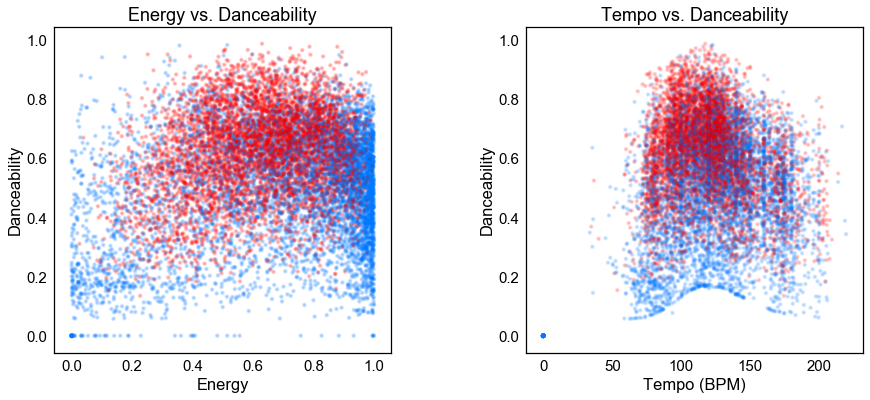

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
p = smooth_scatterplot(df, 'energy', 'danceability', color=True, alpha=.10, 
                       ax=ax1)
p = smooth_scatterplot(df, 'tempo', 'danceability', color=True, alpha=.08, 
                       ax=ax2, xlabel='Tempo (BPM)')
plt.subplots_adjust(wspace=.4)

Now we can see each dataset's contribution to the density of datapoints! 

In the `'energy'` versus `'danceability'` plot, we can see that the Billboard hits (red) are more prevalent in the center, with more tracks from my library (blue) found near the extreme edges. Specifically, it looks like the zero-danceability tracks come from my library, as does the high density of tracks at very high energy (right edge).

In the `'tempo'` versus `'danceability'` plot the billboard hits tend to cluster at high danceability and moderate tempo, with the less-danceable tracks coming from my library. We can also see that all of the zero-danceability, zero-tempo tracks come from my dataset, which we already knew from our previous plot (since `'danceability'=0` is equivalent to `'tempo'=0`).

## Energy versus Loudness

Let's compare a track's loudness to its energy. I'll show the grayscale and color versions of our scatterplot side-by-side.

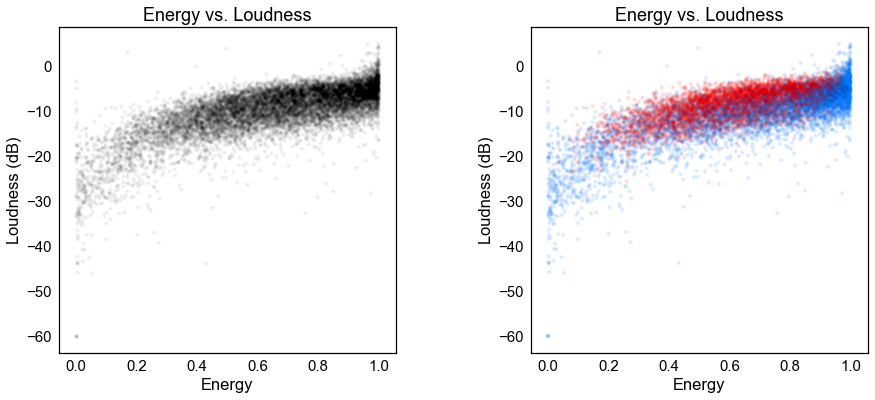

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
p = smooth_scatterplot(df, 'energy', 'loudness', color=False, alpha=.02, 
                       ax=ax1, ylabel='Loudness (dB)')
p = smooth_scatterplot(df, 'energy', 'loudness', color=True, alpha=.04, 
                       ax=ax2, ylabel='Loudness (dB)')
plt.subplots_adjust(wspace=.4)

We can see a vaguely sigmoidal or perhaps logarithmic relationship between `'loudness'` and `'energy'`. For any *particular* energy level, the Billboard hits tend to live on the upper edge of loudness, and the extreme energies are primarily populated by tracks from my library.

Below are the same plots with a linearized ("perceptual") loudness, which do show a *slightly* more linear relationship, but I leave further analysis to the reader.

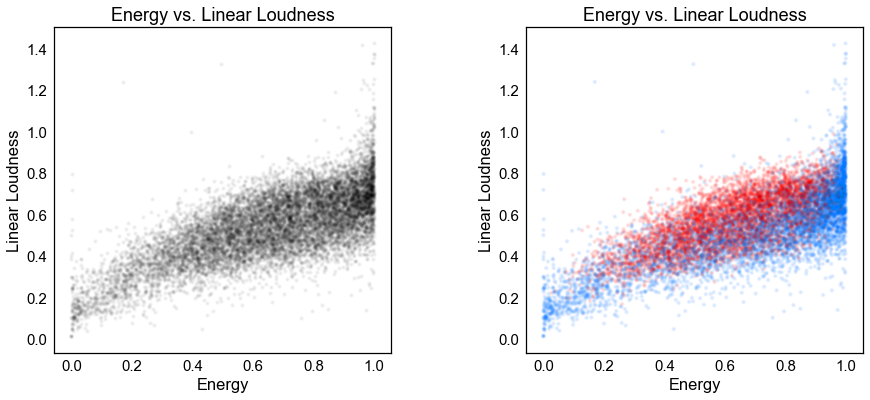

In [11]:
cols = ['energy', 'loudness', 'ds']
df_temp = df[cols].copy()
df_temp['loudness_linear'] = 2**( df_temp.loudness/10 )

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
title = 'Energy vs. Linear Loudness'
p = smooth_scatterplot(df_temp, 'energy', 'loudness_linear', color=False, 
                       alpha=.02, ax=ax1, title=title, ylabel='Linear Loudness')
p = smooth_scatterplot(df_temp, 'energy', 'loudness_linear', color=True, 
                       alpha=.04, ax=ax2, title=title, ylabel='Linear Loudness')
plt.subplots_adjust(wspace=.4)

## Assorted Interactions

Now, let's have a look at a few other interactions, with minimal interpretation.

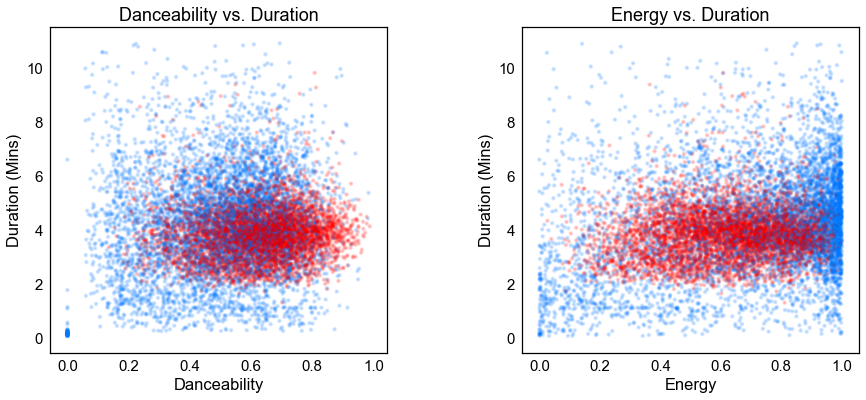

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
ylabel = 'Duration (Mins)'
p = smooth_scatterplot(df[df.duration_mins<11], 'danceability',
                       'duration_mins', color=True, alpha=.08, ax=ax1,
                       ylabel=ylabel, title='Danceability vs. Duration')
p = smooth_scatterplot(df[df.duration_mins<11], 'energy', 
                       'duration_mins', color=True, alpha=.08, ax=ax2,
                       ylabel=ylabel, title='Energy vs. Duration')
plt.subplots_adjust(wspace=.4)

In both of these plots, note the nice elliptical gaussian-like clustering of Billboard hits in the center. These pairs of features might be good candidates for a simple elliptical decision boundary during classification.

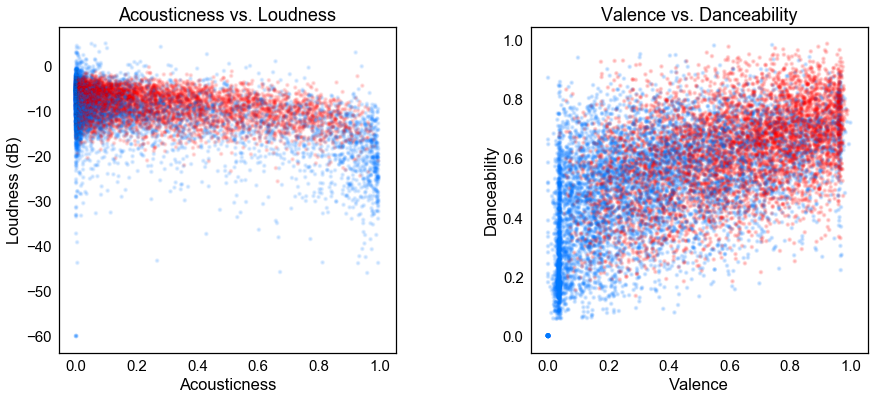

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
p = smooth_scatterplot(df, 'acousticness', 'loudness', color=True, alpha=.06, 
                       ax=ax1, ylabel='Loudness (dB)')
p = smooth_scatterplot(df, 'valence', 'danceability', color=True, alpha=.08, 
                       ax=ax2)
plt.subplots_adjust(wspace=.4)

The `'acousticness'` versus `'loudness'` plot looks *very* similar to the `'energy'` versus `'loudness'` plot we saw earlier, with the $x$-axis flipped.

The `'valence'` versus `'danceability'` plot shows a clear trend of higher valence tracks being more danceable. We also see a bias toward tracks from my library (more blue) transitioning to a bias toward Billboard hits (more red) as we move from low to high valence. The strange vertical line of high density at approximately 0.04 valence (discussed earlier) is also clearly visible here.

# End

This ends our extensive analysis of our dataset's audio features. Before we move on to building a classifier, let's look briefly at **popularity** and how it relates to an artist's **number of followers**.

[Part 4: Social Features](spotify_4_popularity_and_followers.ipynb)

---

< [Part 2: Basic Exploration](spotify_2_basic_exploration.ipynb) | [Main](index.ipynb) | [Part 4: Social Features](spotify_4_popularity_and_followers.ipynb) >